In [88]:
import os
import sys
import h5py
import shutil
import csv
import pandas as pd
from astropy.nddata.utils import Cutout2D
from astropy.io import fits
from astropy import table,coordinates
from astropy import units as u
from astropy.wcs.utils import skycoord_to_pixel
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import (ZScaleInterval, ImageNormalize)
from astropy.visualization import make_lupton_rgb
from astroquery.vizier import Vizier
from collections import Counter
from tensorflow import keras
from astropy.wcs import WCS,utils
import matplotlib.pyplot as plt
from astropy.io import ascii
import fitsio
from esutil import wcsutil
import tensorflow as tf
import tensorflow_probability as tfp
import random
from tensorflow import keras

In [2]:
label_dir = "/home/anahoban/projects/def-sfabbro/anahoban/lensing/GravitationalLensing/Code/Batch Loading/Currently used/labels/"

In [12]:
#merge lists of panstarrs tiles
import csv

og_list = label_dir + 'pans_tiles.list'
DR2_list = label_dir + 'pans_tiles_DR2.list' #which are all i and z bands

with open(DR2_list, 'r') as f:
    new_tiles = [row[0][109:116] for row in csv.reader(f,delimiter='\t')]
    
with open(og_list, 'r') as f:
    old_tiles = [row[0] for row in csv.reader(f,delimiter='\t')]
    
all_tiles= ['PS1.{}.i.fits'.format(tile) for tile in list(set(new_tiles))] + old_tiles + ['PS1.{}.z.fits'.format(tile) for tile in list(set(new_tiles))]    

with open(label_dir + 'all_pans_tiles.list', 'w', newline='') as f:
    writer = csv.writer(f, delimiter='\n' )
    writer.writerow(all_tiles)

In [121]:
def convert_to_float(objects_list, ra_col, dec_col):

    for i, coord in enumerate(objects_list):
        for col in [ra_col, dec_col]:
            try: 
                objects_list[i][col] = float(coord[col])
            except:
                objects_list[i][col] = -float(coord[col][1:])
    return objects_list

## Want to include more candidates:
1. Make list of all candidates coordinates
2. Make list of all ring galaxies
3. Get corresponding tiles
4. Create 200x200 pixels cutouts in all available bands and store them in dataset
5. Visualize them and pick best

# 1. Gathering all known lenses: in currently used/labels/new lenses
- HSC-SSP: https://arxiv.org/abs/2107.07829                              from vizier
- HSC: https://ui.adsabs.harvard.edu/abs/2020A%26A...636A..87C/abstract  chan2020
- HSC: https://ui.adsabs.harvard.edu/abs/2020MNRAS.494.3156J/abstract    1 lens: HSC J0904–0102 : '09:04:29.75 −01:02:28.26'
- SDSS: https://ui.adsabs.harvard.edu/abs/2021MNRAS.502.4617T/abstract   talbot2021: SILO file
- DESI: https://ui.adsabs.harvard.edu/abs/2021arXiv210900014R/abstract   rojas2021
- CFIS papers :                                                          savary2021: '/home/anahoban/projects/rrg-kyi/astro/lenses/unions_paper_lenses.csv'
- masterlens DB or new Swiss database ?

### Create new file with all new lens candidates: 'labels/new_lenses.csv'
## Don't need to run this if file is already created

In [119]:
from astropy.table import Table
Talbot_table = Table.read("/home/anahoban/scratch/" + 'silo_eboss_detections-1.0.1.fits' , memmap=True)
talbot_df = Talbot_table['CATALOG_ID','RA','DEC','TOTAL_GRADE'].to_pandas()

In [122]:
keys = ['Names', 'RA', 'DEC', 'Classification'] 

#chan
chan = open(label_dir + '/new lenses/chan2020.txt', 'r+')
lines = chan.read().split('\n')
chan.close()

chan_data = [line.split(' ')[:4] for line in lines[1:]]
convert_to_float(chan_data,1,2)
chan_df = pd.DataFrame(chan_data, columns = keys)

#rojas
rojas = open(label_dir + '/new lenses/rojas2021.txt', 'r+')
lines = rojas.read().split('\n')
rojas.close()

rojas_data = [line.split(' ')[1:5] for line in lines[1:]]
convert_to_float(rojas_data,1,2)
rojas_df = pd.DataFrame(rojas_data, columns = keys)

#savary
savary = open(label_dir + '/new lenses/savary2021.txt', 'r+')
lines = savary.read().split('\n')
savary.close()

savary_data = [line.split(' ')[1:5] for line in lines[1:]]
convert_to_float(savary_data,1,2)
savary_df = pd.DataFrame(savary_data, columns = keys)

#Jaelani (1 lens)
ra_dec = coordinates.SkyCoord('09:04:29.75 −01:02:28.26', unit=(u.hourangle, u.deg))
jae_data = [('HSCJ0904–0102', ra_dec.ra.deg, ra_dec.dec.deg, 3.0)]

#talbot
talbot_df.rename(columns={'CATALOG_ID': keys[0], 'TOTAL_GRADE': keys[-1]})

,Names,RA,DEC,Classification
0,0,30.799484,-0.376353,b'B-'
1,1,32.393986,0.246297,b'B+'
2,2,37.707367,-0.543282,b'B-'
3,3,37.892769,0.412356,b'A+'
4,4,36.530914,1.171299,b'A+'
...,...,...,...,...
1546,1546,166.835144,29.384171,b'C-'
1547,1547,177.766769,30.591610,b'A+'
1548,1548,353.941803,9.510032,b'C-'
1549,1549,356.144073,10.454764,b'A+'


In [123]:
#canameras lenses
lenses_cana = Vizier.get_catalogs(catalog="J/A+A/644/A163")[0]

#extracting relevent columns

cana_names = list(lenses_cana['Name'])#,'RAJ2000','DEJ2000','Grade']]
cana_ra = np.array(list(lenses_cana['RAJ2000']))
cana_dec = np.array(list(lenses_cana['DEJ2000']))
cana_grade = list(lenses_cana['Grade'])

#converting to ra&dec
ra_dec_degrees = [coordinates.SkyCoord( (cana_ra[i] + ' ' + cana_dec[i]),unit=(u.hourangle, u.deg)) for i in range(0, len(cana_ra))]
cana_ra_deg= [ coord.ra.deg  for coord in ra_dec_degrees]
cana_dec_deg= [ coord.dec.deg for coord in ra_dec_degrees]


cana_data = [ (cana_names[i], cana_ra_deg[i], cana_dec_deg[i], cana_grade[i]) for i in range(len(cana_names)) ]


jae_cana_df = pd.DataFrame(cana_data+jae_data, columns = keys)

In [124]:
new_cand_dfs = [chan_df, rojas_df, savary_df, jae_cana_df, talbot_df]
all_new_lenses = pd.concat(new_cand_dfs)

#save new lenses to csv
all_new_lenses.to_csv(label_dir + 'new_lenses.csv')

### Combine with previous candidates (ra_dec.csv) 

In [125]:
keys = ['Names', 'RA', 'DEC', 'Classification', 'Tile', 'X', 'Y'] 
new_list = pd.read_csv(label_dir + 'new_lenses.csv')[keys[:-3]]
old_list = pd.read_csv(label_dir + 'ra_dec.csv')

old_with_xy = pd.DataFrame([ ['previous', old_list['ra'][i],old_list['dec'][i], '--', 'tbd', 'tbd', 'tbd' ] for i in range(len(old_list))], columns = keys)
new_with_xy = pd.DataFrame([ [new_list['Names'][i], new_list['RA'][i], new_list['DEC'][i], new_list['Classification'][i], 'tbd', 'tbd', 'tbd' ] for i in range(len(new_list))], columns = keys)

#save in file
all_lenses = pd.concat([new_with_xy, old_with_xy])
all_lenses.to_csv(label_dir + 'all_lenses.csv')

# 2. Add ring galaxies: in currently used/labels/new lenses/rings
- PanSTARRS: https://ui.adsabs.harvard.edu/abs/2017ApJS..231....2T/abstract 

    185 Ring Galaxy Candidates Identified Automatically
    
    18 Collisional Ring Galaxies from (Madore et al. 2009) That Are Inside the Footprint of PanSTARRS DR1
    
- SDSS: https://ui.adsabs.harvard.edu/abs/2020MNRAS.491.3767S/abstract

    443 Ring galaxies in SDSS
    
- DESI (same paper as in 1) <--can't find the cat

In [9]:
ring_ps1 = 'rings/ringsPS1.txt'
ring_sdss = 'rings/ringsSDSS.txt'
keys = ['Name', 'RA', 'DEC']

In [29]:
#PS1
rings = open(label_dir + ring_ps1, 'r+')
lines = rings.read().split('\n')
rings.close()

rings_ps1_data = [line.split(' ')[1:4] for line in lines[1:]]
convert_to_float(rings_ps1_data,1,2)
rings_ps1_df = pd.DataFrame(data = rings_ps1_data[:202], columns = keys)

#sdss
rings = open(label_dir + ring_sdss, 'r+')
lines = rings.read().split('\n')
rings.close()

rings_sdss_data = [line.split(' ')[:3] for line in lines[1:]] + [line.split(' ')[3:6] for line in lines[1:]] + [line.split(' ')[6:9] for line in lines[1:]] + [line.split(' ')[9:] for line in lines[1:]]
convert_to_float(rings_sdss_data[:-1],1,2)
rings_sdss_df = pd.DataFrame(data = rings_sdss_data[:-1], columns = keys)


In [30]:
rings_df = [rings_ps1_df, rings_sdss_df]
all_rings = pd.concat(rings_df)
all_rings.to_csv(label_dir + 'all_rings.csv')

## Cross Match lenses and rings catalogues and remove duplicates
### Note: there is no duplicate for now!

In [37]:
#0.1857 arcsecond per pixel
#so 1 arcsec error gives (in degrees):

# 3 pixels --> 0.5 arcsecond
err = 1/3600

In [3]:
#get catalogues and remove iduplicates
all_rings  = pd.read_csv(label_dir + 'all_rings.csv').drop_duplicates(subset=['RA', 'DEC'], keep='first')
all_lenses = pd.read_csv(label_dir + 'all_lenses.csv').drop_duplicates(subset=['RA', 'DEC'], keep='first')
#plot on sky to see if there are other duplicates**

In [94]:
rings_array  = np.array(all_rings[['RA','DEC']])
lenses_array = np.array(all_lenses[['RA','DEC']])

In [95]:
print('there are', len(lenses_array), 'unique lenses')

there are 7146 unique lenses


In [96]:
lens_is_ring = []
for ring in rings_array:
    diff_ra, diff_dec = zip(*(lenses_array-ring))
    
    for i in range(len(diff_ra)):
        if np.abs(diff_ra[i]) <= err and np.abs(diff_dec[i]) <= err:
            print(lenses_array[i], ring)
            lens_is_ring.append((lenses_array[i]) )

In [97]:
print('there are', len(lens_is_ring), 'lenses that are rings')

there are 0 lenses that are rings


# 3. Match the lenses to some tile(s)
## 3.1 Find ra-dec range for each available tile

In [140]:
# The tiles are 10000x10000 pixels with a pixel size of 0.1857 arcsecond per pixel
# The tiles have names in the format CFIS.xxx.yyy.f.fits. xxx and yyy correspond to the RA, Dec of the tile centres as follows:
# how the tile names were made:
### xxx=ra*2*cos(dec)
### yyy=(dec+90)*2
### dec=yyy/2-90
### ra=xxx/2/cos(dec)

In [58]:
#useful info for CFIS
res =  0.1857 #arcsecond per pixel
res *= 1/3600 #degrees per pixel
size = 10000  #pixels
deg_range = size/2 * res #range from central value

In [59]:
deg_range

0.2579166666666667

In [60]:
#useful funtions
import math
def tile_to_coord(tile, return_ra = False, return_dec = False):
    '''correspondance in degrees of ra,dec of tile name'''
    xxx,yyy = tile.split('.')
    dec  = int(yyy)/2 - 90
    ra = int(xxx)/(2*np.cos(math.radians(dec)))
    
    if return_ra is True:
        return ra
    if return_dec is True:
        return dec
    
def coord_to_tile(ra, dec, row):
    '''takes ra and dec coord (in degrees) and outputs the tile name centered there'''
    #convert to radians
    try: 
        xxx = str(int(ra*2*np.cos(math.radians(dec))))
        yyy = str(int(2*(dec+90)))
        if len(xxx) == 0 :
            xxx = '000'
        if len(xxx) == 1 :
            xxx = '00'+xxx
        if len(xxx) == 2 :
            xxx = '0'+xxx

        if len(yyy) == 0 :
            yyy = '000'
        if len(yyy) == 1 :
            yyy = yyy + '00'
        if len(yyy) == 2 :
            yyy = yyy + '0'
        return xxx + '.' + yyy
    except:
        print('ra and dec are not a number', row)
        return 0
    

In [61]:
# test functions above
print(tile_to_coord('100.234'))
print(coord_to_tile(56.11631188171804, 27.0, 1))

None
100.234


In [100]:
#load list of tiles
tiles_table = pd.read_csv(label_dir + 'tiles_summary.csv', dtype={'Tile':str})
tiles_table.head()

,Unnamed: 0,Tile,CFIS_u,CFIS_r,PS1_g,PS1_i,PS1_z,HSC_g,HSC_z,band_nb
0,0,343.264,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2
1,1,199.237,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,2,660.221,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,3,259.245,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2
4,4,205.270,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1


In [101]:
tiles_table = tiles_table.drop(columns = ['Unnamed: 0'])#, 'Unnamed: 0.1', 'RA_center', 'DEC_center', 'RA_0', 'RA_1', 'DEC_0', 'DEC_1', 'band_nb'])

In [102]:
#RA at center of tile
tiles_table['RA_center']  = tiles_table.apply(lambda row: tile_to_coord(row['Tile'], return_ra = True), axis = 1)
#DEC at center of tile
tiles_table['DEC_center'] = tiles_table.apply(lambda row: tile_to_coord(row['Tile'], return_dec = True), axis = 1)

#tiles_table[['RA_0', 'RA_1']] = pd.DataFrame(tiles_table['RA'].tolist(), index=tiles_table.index)
#tiles_table[['DEC_0', 'DEC_1']] = pd.DataFrame(tiles_table['DEC'].tolist(), index=tiles_table.index)
#tiles_table[tiles_table['RA'] <= 143 ]
tiles_table.head()

,Tile,CFIS_u,CFIS_r,PS1_g,PS1_i,PS1_z,HSC_g,HSC_z,band_nb,RA_center,DEC_center
0,343.264,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2,230.776013,42.0
1,199.237,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,113.220372,28.5
2,660.221,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,352.311090,20.5
3,259.245,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2,153.546732,32.5
4,205.270,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,144.956890,45.0


In [103]:
tiles_table['RA_0'] = tiles_table['RA_center'] - deg_range
tiles_table['RA_1'] = tiles_table['RA_center'] + deg_range
tiles_table['DEC_0'] = tiles_table['DEC_center'] - deg_range
tiles_table['DEC_1'] = tiles_table['DEC_center'] + deg_range

In [104]:
#get number of bands available for each tile
bands = list(tiles_table.keys())[1:8] #leaving hcs_z out
def nb_bands(row):
    i = 0
    for band in bands:
        if row[band] != 0:
            i += 1
    return i

tiles_table['band_nb'] = tiles_table.apply(lambda row: nb_bands(row), axis = 1)

In [105]:
#update file
tiles_table.to_csv(label_dir + 'tiles_summary.csv')

## 3.2 Match each candidate's coord to some tile's ra,dec ranges 

In [ ]:
#now we want to fill the Tile, X and Y columns of this table
#for each candidate we'll determine what tile it is in and which are its X,Y coordinates

#1 : for each tile in tile_tables, find the ra and dec range
#2 : for each range, determine which lenses in all lenses fall in it
#3 : for each lens in a tile, write in all_lenses the tile
#4 : Find the X, Y coordinates for that tile

In [106]:
all_lenses = pd.read_csv(label_dir + 'all_lenses.csv', dtype={'Tile':str})
#tiles_table = pd.read_csv(label_dir + 'tiles_summary.csv', dtype={'Tile':str})

In [107]:
def in_tile(ra, dec):
    tiles_list =  tiles_table[['Tile', 'band_nb']][ (tiles_table['RA_0'] <= ra) & (tiles_table['RA_1'] >= ra) & (tiles_table['DEC_0'] <= dec) & (tiles_table['DEC_1'] >= dec)]
    tile = list(tiles_list['Tile'])
    band_nb = list(tiles_list['band_nb'])
    
    if len(tile) > 0 : #tile with highest number of bands only
        return tile[band_nb.index(max(band_nb))]
    else:
        return 0 #no matching tile

all_lenses['Tile'] = all_lenses.apply(lambda row: in_tile(row['RA'], row['DEC']), axis = 1)

In [108]:
tile = '356.182'
ra_dec_list = [(row.RA, row.DEC) for index, row in lenses_in_survey[lenses_in_survey.Tile == tile][['RA','DEC']].iterrows()]
    

In [109]:
#how many unique tiles do I need to download
def flatten(t):
    #to flatten a list
    return [item for sublist in t for item in sublist]

tiles_w_candidates = list(set(all_lenses['Tile'][all_lenses['Tile'] != 0]))

In [110]:
print('in total there are', len(tiles_table), 'tiles, and', len(all_lenses), 'candidates')
print(len(all_lenses[all_lenses['DEC']>= 0]), 'are in the northern hemisphere of the sky (dec>0)')
print(len(all_lenses[all_lenses['Tile'] != 0]), "lenses can be found in the survey's tiles so far")
print()
print('There are tiles with more than one candidate, there are', len(tiles_w_candidates), 'unique tiles containing candidates')

in total there are 33770 tiles, and 7181 candidates
3946 are in the northern hemisphere of the sky (dec>0)
2252 lenses can be found in the survey's tiles so far

There are tiles with more than one candidate, there are 1969 unique tiles containing candidates


In [111]:
nb_of_bands = []
for tile in tiles_w_candidates:
    nb_of_bands.append(list(tiles_table['band_nb'][tiles_table['Tile'] == tile]))

In [112]:
all_lenses.to_csv(label_dir + 'all_lenses.csv')

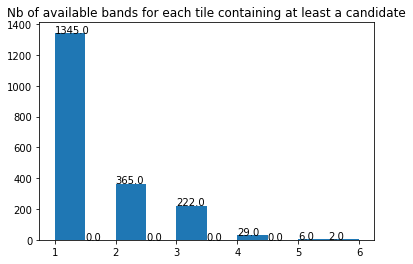

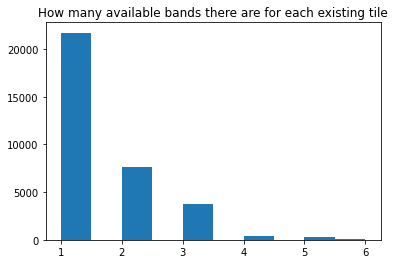

In [113]:
plt.title('Nb of available bands for each tile containing at least a candidate')

data=flatten(nb_of_bands)
arr=plt.hist(data)
for i in range(10):
    plt.text(arr[1][i],arr[0][i],str(arr[0][i]))

plt.show()
plt.title('How many available bands there are for each existing tile')
plt.hist(tiles_table['band_nb']);

## 3.3 Visualization of candidates and all tiles on the sky

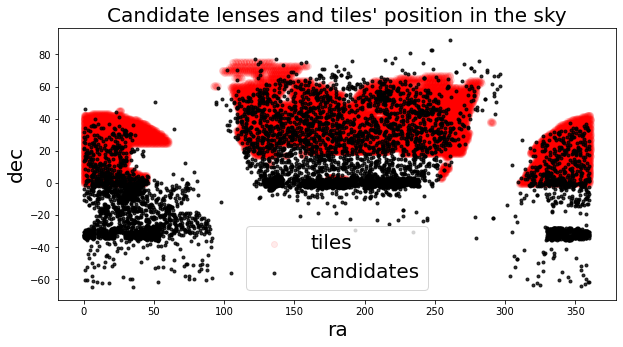

In [91]:
plt.figure(figsize = [10,5])
plt.scatter(tiles_table['RA_center'], tiles_table['DEC_center'], c = 'r', alpha = 0.08, label = 'tiles' )
plt.scatter(all_lenses['RA'], all_lenses['DEC'], marker = '.',c = 'k', alpha = 0.8, label = 'candidates')
plt.title("Candidate lenses and tiles' position in the sky", fontsize = 20)
plt.legend(fontsize = 20)
plt.ylabel('dec', fontsize = 20)
plt.xlabel('ra', fontsize = 20);

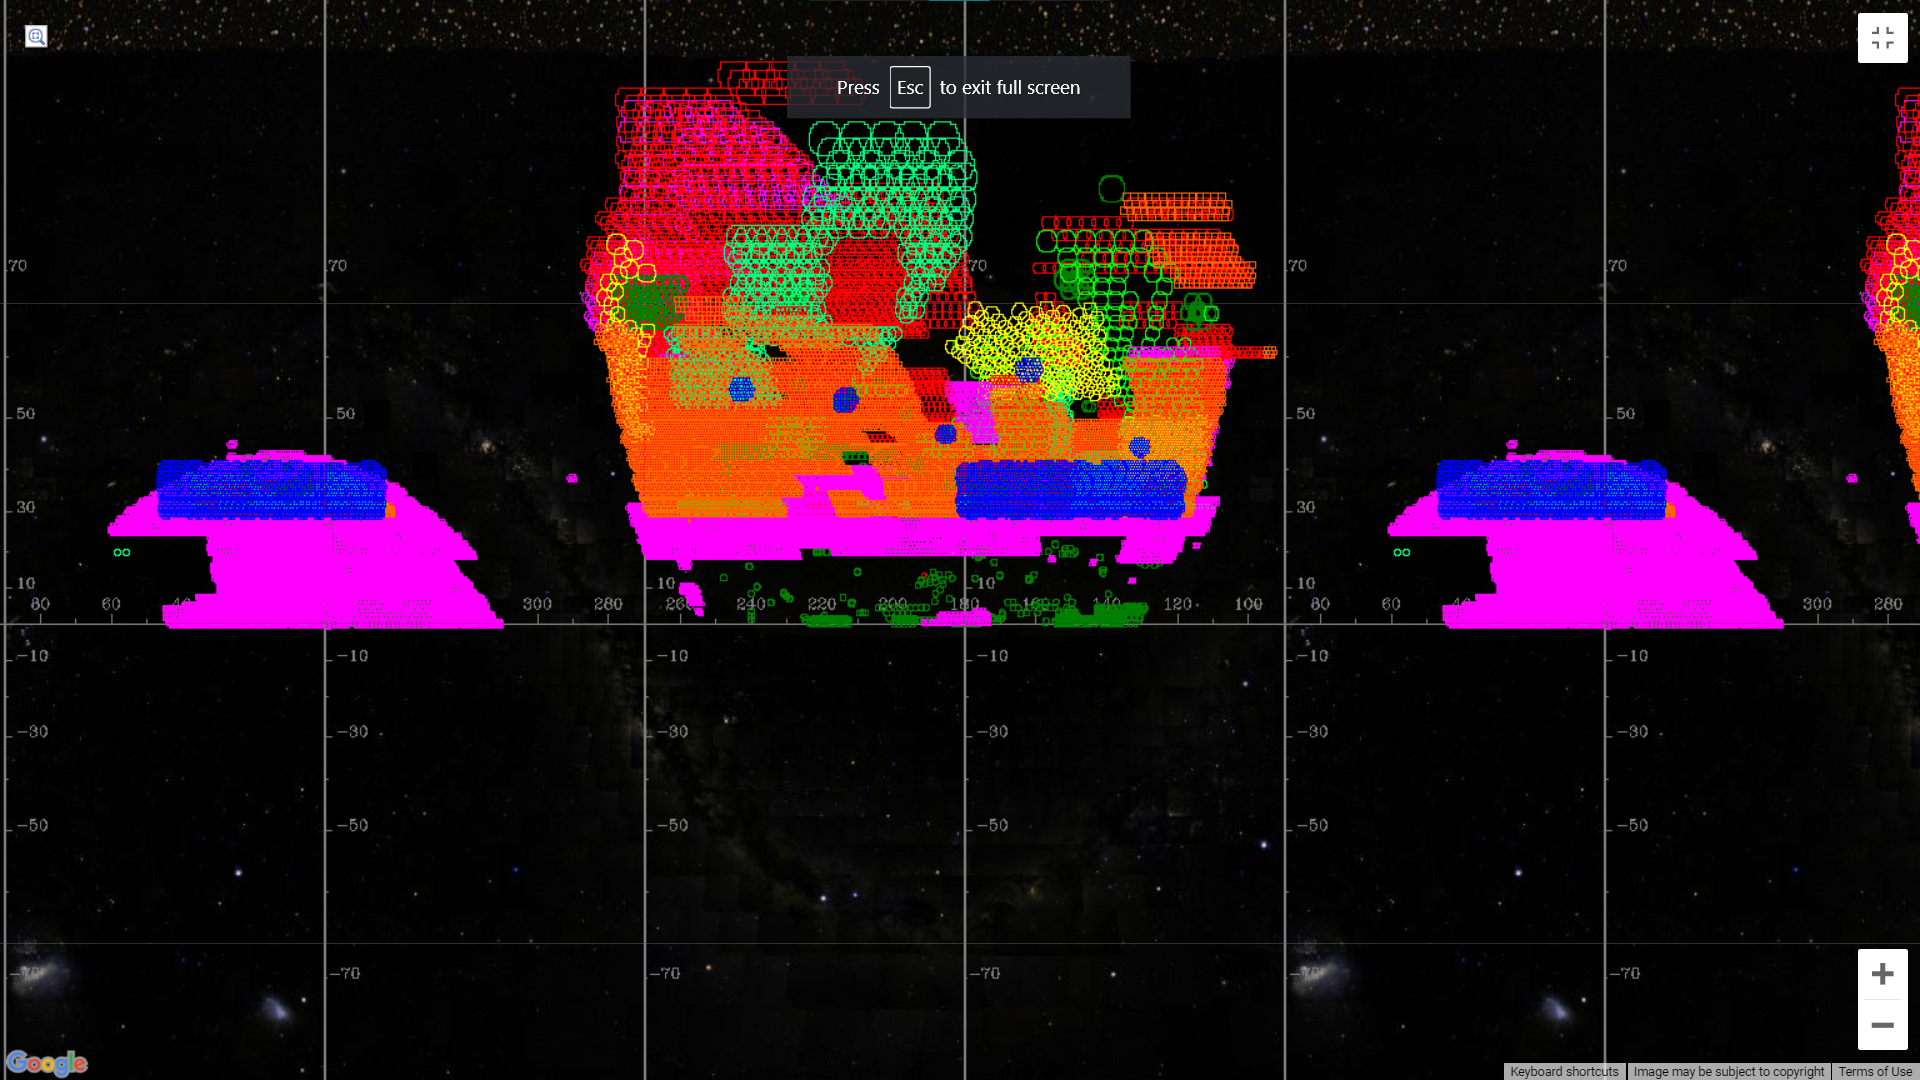

# Run from here

## Selecting only lenses in survey and looking at candidates!!!

In [114]:
all_lenses  = pd.read_csv(label_dir + 'all_lenses.csv', dtype={'Tile':str})
tiles_table = pd.read_csv(label_dir + 'tiles_summary.csv', dtype={'Tile':str})

In [115]:
#tiles_table = tiles_table.drop(columns = ['Unnamed: 0'])#,'Unnamed: 0.1'])
all_lenses  = all_lenses.drop(columns  = ['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1.1'])

In [116]:
lenses_in_survey = all_lenses[all_lenses['Tile'] != '0']

In [117]:
tiles_table.head()

,Unnamed: 0,Tile,CFIS_u,CFIS_r,PS1_g,PS1_i,PS1_z,HSC_g,HSC_z,band_nb,RA_center,DEC_center,RA_0,RA_1,DEC_0,DEC_1
0,0,343.264,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2,230.776013,42.0,230.518096,231.033930,41.742083,42.257917
1,1,199.237,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,113.220372,28.5,112.962455,113.478288,28.242083,28.757917
2,2,660.221,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,352.311090,20.5,352.053173,352.569007,20.242083,20.757917
3,3,259.245,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2,153.546732,32.5,153.288815,153.804648,32.242083,32.757917
4,4,205.270,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,144.956890,45.0,144.698973,145.214807,44.742083,45.257917


In [78]:
print(len(lenses_in_survey), 'lenses in the survey')

2252 lenses in the survey


In [118]:
#get the band number for each of the lenses in the survey
lenses_in_survey['band_nb'] = 0 #initializing column
for index,row in lenses_in_survey.iterrows():
    tile = row['Tile']
    lenses_in_survey['band_nb'][lenses_in_survey.Tile == row['Tile']] = tiles_table[tiles_table.Tile == tile ]['band_nb'].item()


<ipython-input-118-cecad5058946>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lenses_in_survey['band_nb'] = 0 #initializing column
<ipython-input-118-cecad5058946>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lenses_in_survey['band_nb'][lenses_in_survey.Tile == row['Tile']] = tiles_table[tiles_table.Tile == tile ]['band_nb'].item()
/home/anahoban/umap/lib/python3.8/site-packages/pandas/core/series.py:992: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.

In [126]:
lenses_in_survey.head()
lenses_in_survey.drop(columns = ['Unnamed: 0.1.1', 'Unnamed: 0.1.1.1.1'])

,Names,RA,DEC,Classification,Tile,X,Y,band_nb
1,HSCJ115252+004733†,178.2180,0.7930,1.3900,356.182,tbd,tbd,1
7,HSCJ223406+012057,338.5290,1.3490,1.2400,677.183,tbd,tbd,1
8,HSCJ222801+012805,337.0080,1.4680,1.6000,674.183,tbd,tbd,1
13,HSCJ224221+001144,340.5900,0.1960,1.4100,681.180,tbd,tbd,1
14,HSCJ223359+015826,338.5000,1.9740,0.8500,677.184,tbd,tbd,1
...,...,...,...,...,...,...,...,...
7167,previous,202.3729,31.3290,--,345.243,tbd,tbd,2
7169,previous,204.6057,28.3294,--,360.237,tbd,tbd,1
7171,previous,216.1003,25.2423,--,390.231,tbd,tbd,1
7178,previous,317.3884,5.1456,--,632.190,tbd,tbd,1


In [127]:
tiles_table[tiles_table.Tile == '356.182']

,Unnamed: 0,Tile,CFIS_u,CFIS_r,PS1_g,PS1_i,PS1_z,HSC_g,HSC_z,band_nb,RA_center,DEC_center,RA_0,RA_1,DEC_0,DEC_1
23074,23074,356.182,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,178.027114,1.0,177.769198,178.285031,0.742083,1.257917


In [128]:
lenses_in_survey.to_csv('lenses_in_survey.csv')

In [129]:
lenses_in_survey = pd.read_csv('lenses_in_survey.csv', dtype={'Tile':str} )
tiles_table = pd.read_csv(label_dir + 'tiles_summary.csv', dtype={'Tile':str})
tiles_with_lenses = list(lenses_in_survey['Tile'].unique())

In [132]:
#make the urgz list for each tile
keys = ['CFIS_u', 'CFIS_r', 'PS1_g', 'PS1_i', 'PS1_z','HSC_g']
key_dict = {'CFIS_u': 'u', 'CFIS_r': 'r', 'PS1_g' : 'G', 'PS1_i': 'i', 'PS1_z': 'z','HSC_g': 'g'}
band2cam = {v: k[:-2] for k, v in key_dict.items()}
band2index = {'u':0, 'r':1, 'g':2, 'i':3, 'z':4}

band_to_mask = { 'u' : '.weight.fits.fz ',
                 'r' : '.weight.fits.fz ',
                 'i' : '.wt.fits ',
                 'z' : '.wt.fits ',
                 'G' : '.wt.fits ',
                 'g' : '.weight.fits.fz '}
bands_list = []
for index, row in tiles_table.iterrows():
    bands = ''
    for key in keys:
        if row[key] == 1:
            bands += key_dict[key]
    bands_list.append(bands)
    
tiles_table['bands_list'] = bands_list

In [133]:
bands_survey_tiles = []
for tile in list(lenses_in_survey['Tile']):
    bands_survey_tiles.append(tiles_table.loc[tiles_table.Tile == tile, 'bands_list'].iloc[0])
lenses_in_survey['bands_list'] = bands_survey_tiles

Text(0.5, 1.0, 'Band availability histogram for all tiles')

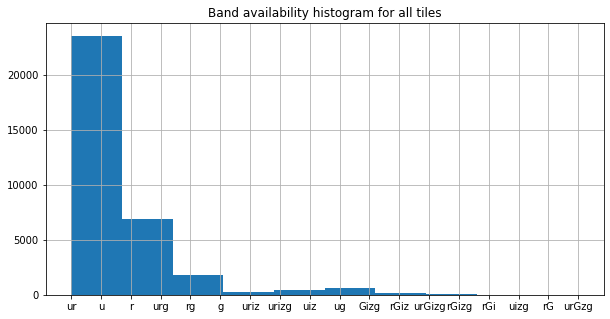

In [134]:
tiles_table['bands_list'].hist(figsize = (10,5))
plt.title('Band availability histogram for all tiles')

Text(0.5, 1.0, 'Band availability histogram for candidates')

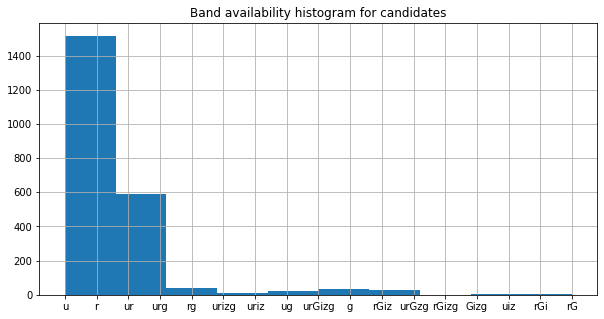

In [135]:
lenses_in_survey['bands_list'].hist(figsize = (10,5))
plt.title('Band availability histogram for candidates')

In [136]:
lenses_in_survey[lenses_in_survey.bands_list == 'urig']

,Unnamed: 0,Unnamed: 0.1.1,Unnamed: 0.1.1.1.1,Names,RA,DEC,Classification,Tile,X,Y,band_nb,bands_list


In [138]:
tiles_table.to_csv(label_dir + 'tiles_summary.csv')
lenses_in_survey.to_csv('lenses_in_survey.csv')

## Renaming the ps1 dr2 tiles in i and z i scratch/all_lenses


In [52]:
scratch = os.path.expandvars("$SCRATCH") + '/'

with open('dr2_used_tiles.list', 'r') as f:
    iz_used_tiles = [row[0] for row in csv.reader(f,delimiter='\t')]


In [101]:
tile = iz_used_tiles[0].split('.')[3] + '.' + iz_used_tiles[1].split('.')[4]
img_or_wt = iz_used_tiles[1].split('.')[8]

In [104]:
for filename in iz_used_tiles:
    #get band
    fits = fitsio.FITS(scratch + 'all_lenses/' + filename)
    band = fits[1].read_header()['HIERARCH FPA.FILTER'].split('.')[0]
    
    #get tile + type of file info
    key_words = filename.split('.')
    tile = key_words[3] + '.' + key_words[4]
    img_or_wt = key_words[8]
    
    if img_or_wt == 'wt':
        new_name = 'PS1.' + tile + '.' + band + '.wt.fits' 
    elif img_or_wt == 'fits':
        new_name = 'PS1.' + tile + '.' + band + '.fits' 
    print(new_name)    
    
    os.rename(scratch + 'all_lenses/' + filename, scratch + 'all_lenses/' + new_name)    

PS1.001.243.i.fits
PS1.001.243.i.wt.fits
PS1.001.243.z.fits
PS1.001.243.z.wt.fits
PS1.005.238.i.fits
PS1.005.238.i.wt.fits
PS1.005.238.z.fits
PS1.005.238.z.wt.fits
PS1.005.246.i.fits
PS1.005.246.i.wt.fits
PS1.005.246.z.fits
PS1.005.246.z.wt.fits
PS1.008.244.i.fits
PS1.008.244.i.wt.fits
PS1.008.244.z.fits
PS1.008.244.z.wt.fits
PS1.009.251.i.fits
PS1.009.251.i.wt.fits
PS1.009.251.z.fits
PS1.009.251.z.wt.fits
PS1.011.251.i.fits
PS1.011.251.i.wt.fits
PS1.011.251.z.fits
PS1.011.251.z.wt.fits
PS1.011.252.i.fits
PS1.011.252.i.wt.fits
PS1.011.252.z.fits
PS1.011.252.z.wt.fits
PS1.012.239.i.fits
PS1.012.239.i.wt.fits
PS1.012.239.z.fits
PS1.012.239.z.wt.fits
PS1.012.251.i.fits
PS1.012.251.i.wt.fits
PS1.012.251.z.fits
PS1.012.251.z.wt.fits
PS1.013.259.i.fits
PS1.013.259.i.wt.fits
PS1.013.259.z.fits
PS1.013.259.z.wt.fits
PS1.017.239.i.fits
PS1.017.239.i.wt.fits
PS1.017.239.z.fits
PS1.017.239.z.wt.fits
PS1.017.253.i.fits
PS1.017.253.i.wt.fits
PS1.017.253.z.fits
PS1.017.253.z.wt.fits
PS1.019.237.i.fi

### Making sure all tiles were downloaded in scratch
#### (after running download_tiles.py)

In [4]:
scratch = os.path.expandvars("$SCRATCH") + '/'
tiles_scratch = os.listdir(scratch+'all_lenses')

In [21]:
all_tiles_downloaded = []
for file in tiles_scratch:
    if file[0] == 'C':
        tile = file[5:12]
    if file[0] in ['P', 'H']:
        tile = file[4:11]
    all_tiles_downloaded.append(tile)

In [23]:
len(list(set(list(all_tiles_downloaded))))
#and there are 1969 tiles, so good!

1970

In [26]:
for t in all_tiles_downloaded:
    if t not in tiles_with_lenses:
        print(t)

581.248
581.248


In [104]:
#some tiles are missing: the DR2 ps1 tiles!
ps1_tiles = []
for tile in tiles_with_lenses:
    if tiles_table[tiles_table.Tile == tile].PS1_i.item() == 1.0:
        ps1_tiles.append(tile)

## Making sure hf file is okay

In [3]:
scratch = os.path.expandvars("$SCRATCH") + '/'
hf_1 = h5py.File(scratch + 'Dataset_run2_2.h5', "r") #0 to 500

In [4]:
keys = hf_1.keys()

In [5]:
list_keys = list(keys)

In [9]:
list_keys[200:210]

['000.237_99',
 '001.207_0',
 '001.207_1',
 '001.207_10',
 '001.207_100',
 '001.207_101',
 '001.207_102',
 '001.207_103',
 '001.207_104',
 '001.207_105']

In [6]:
len(list_keys)

99533

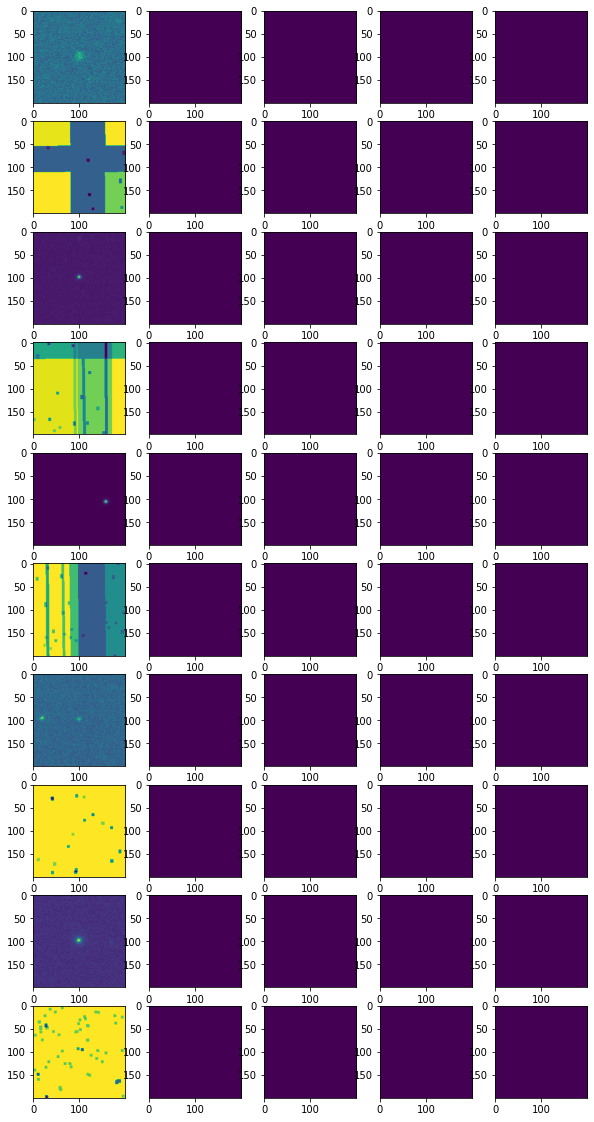

In [11]:
fig, axs = plt.subplots(10,5,figsize= [10,20])
img = 0
while img < 10:
    for i in range(5):
        axs[img,i].imshow(np.array(hf_1.get('000.237_'+str(img)))[...,i])
        axs[img+1,i].imshow(np.array(hf_1.get('000.237_'+str(img)))[...,i+5])
    img += 2

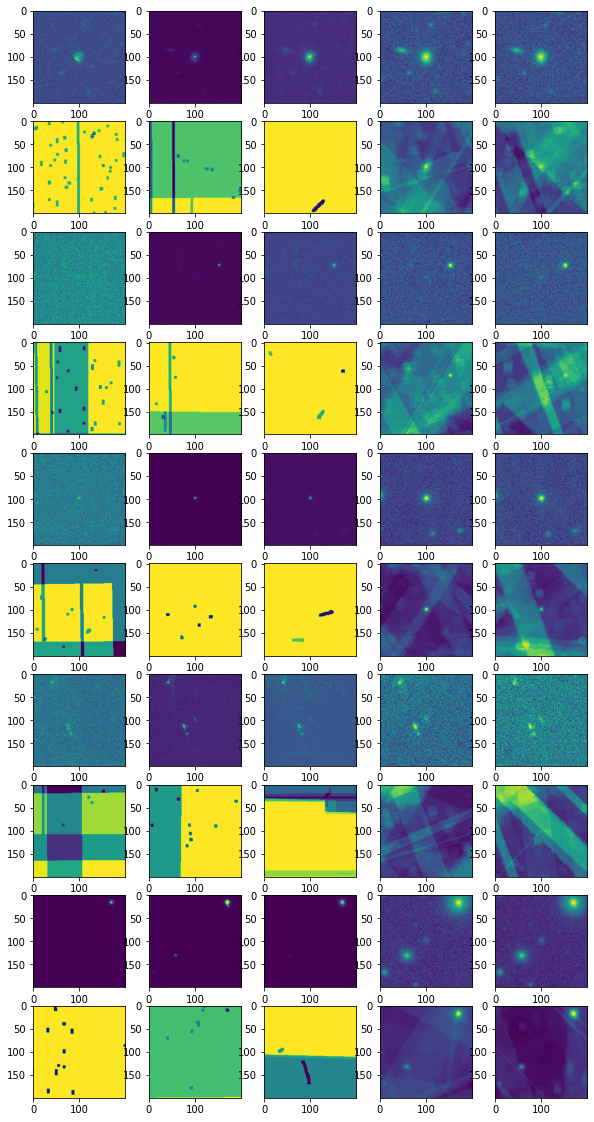

In [23]:
fig, axs = plt.subplots(10,5,figsize= [10,20])
img = 0
while img < 10:
    for i in range(5):
        axs[img,i].imshow(np.array(hf_1.get('005.246_'+str(img)))[...,i])
        axs[img+1,i].imshow(np.array(hf_1.get('005.246_'+str(img)))[...,i+5])
    img += 2

In [226]:
hf.close()

## Finding mode of distribution

In [1]:
import os
import sys
import shutil
import csv
import pandas as pd
from astropy.io import fits
from astropy import table,coordinates
from astropy.wcs import WCS,utils
import matplotlib.pyplot as plt
from astropy.io import ascii
import fitsio
from esutil import wcsutil

In [3]:
big_cat = '/home/anahoban/projects/rrg-kyi/astro/unions/unions.ugriz.fits'
tmp_dir = os.path.expandvars("$SLURM_TMPDIR") + '/'

#shutil.copy2(big_cat, tmp_dir)

In [4]:
#had to pip install streamlit==0.62.0 bc pyarrow wouldn't install
df = pd.read_parquet('/home/anahoban/projects/rrg-kyi/astro/unions/unions.ugriz.parquet')

In [5]:
df.head()

,RA,Dec,CFIS_ID,CFIS_U_MAG_AUTO,CFIS_U_MAGERR_AUTO,HSC_G_MAG_AUTO,HSC_G_MAGERR_AUTO,CFIS_R_MAG_AUTO,CFIS_R_MAGERR_AUTO,PS_i_stk_kron,PS_i_stk_kron_err,PS_z_stk_kron,PS_z_stk_kron_err,CFIS_R_StarGal
0,0.050347,30.00161,2000240003934,-99.0,-99.0,-99.0,-99.0,22.385,0.038,22.714,0.094,22.217,0.151,1.946
1,0.036178,30.00156,2000240003938,-99.0,-99.0,-99.0,-99.0,23.259,0.109,22.154,0.097,21.421,0.111,2.184
2,0.109960,30.00237,2000240003943,-99.0,-99.0,-99.0,-99.0,23.802,0.131,-99.000,-99.000,-99.000,-99.000,3.416
3,0.016088,30.00157,2000240003945,-99.0,-99.0,-99.0,-99.0,25.132,0.267,-99.000,-99.000,-99.000,-99.000,1.255
4,0.003157,30.00158,2000240003947,-99.0,-99.0,-99.0,-99.0,25.116,0.148,-99.000,-99.000,-99.000,-99.000,0.326


<AxesSubplot:xlabel='CFIS_R_MAG_AUTO', ylabel='Count'>

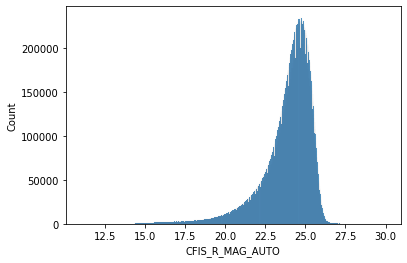

In [4]:
import seaborn as sns
sns.histplot(df['CFIS_R_MAG_AUTO'])

Text(0.5, 1.0, 'Mode of distribution is at 24.665777')

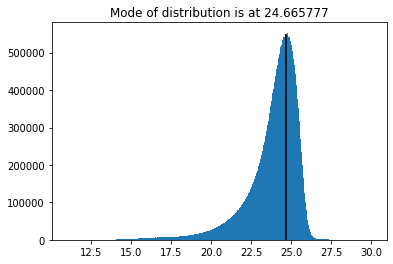

In [28]:
hist = plt.hist(df['CFIS_R_MAG_AUTO'], bins = 1000);
peak = np.where(hist[0] == np.max(hist[0], where=True))

mag_mode = hist[1][peak][0]
plt.vlines(mag_mode, ymin = 0, ymax=550000, colors='k')
plt.title('Mode of distribution is at ' + str(mag_mode))

### So we take the cut at 24.66-0.5 ~ 24.12

In [3]:
scratch = os.path.expandvars("$SCRATCH") + '/'
files_dir = scratch + 'all_lenses/'

ex_cat = files_dir + 'CFIS.005.246.u.cat'
example = table.Table.read(ex_cat, format="ascii.sextractor")

In [38]:
cat  = example[example['MAG_AUTO'] <= mag_mode].to_pandas().sample(200)

In [57]:
cat[cat.index == 2378]['NUMBER'].item()

3759

# Creating dataset

In [ ]:
import tensorflow as tf

#define useful directories
scratch = os.path.expandvars('$SCRATCH') + '/'
h5_names = ['Dataset_run2_'+ str(i+1) + '.h5' for i in range(3)]

hf_1 = h5py.File(scratch + h5_names[0], "r")
hf_2 = h5py.File(scratch + h5_names[1], "r")
hf_3 = h5py.File(scratch + h5_names[2], "r")
hf_4 = h5py.File(scratch + h5_names[2], "r")

gen_1 = lambda: (tf.expand_dims(hf_1.get(key), axis=0) for key in hf_1.keys())
gen_2 = lambda: (tf.expand_dims(hf_2.get(key), axis=0) for key in hf_2.keys())
gen_3 = lambda: (tf.expand_dims(hf_3.get(key), axis=0) for key in hf_3.keys())
gen_4 = lambda: (tf.expand_dims(hf_4.get(key), axis=0) for key in hf_4.keys())

print('starting dataset creation')
shapes = (1,200,200,10)
dataset_1 = tf.data.Dataset.from_generator(gen_1, output_types=(tf.float64),output_shapes=shapes)
dataset_2 = tf.data.Dataset.from_generator(gen_2, output_types=(tf.float64),output_shapes=shapes)
dataset_3 = tf.data.Dataset.from_generator(gen_3, output_types=(tf.float64),output_shapes=shapes)
dataset_4 = tf.data.Dataset.from_generator(gen_4, output_types=(tf.float64),output_shapes=shapes)

combined_dataset = dataset_1.concatenate(dataset_2).concatenate(dataset_3).concatenate(dataset_4)
#save dataset
tf.data.experimental.save(combined_dataset, path = scratch + 'autoencoder_full_dataset')

starting dataset creation


In [3]:
combined_dataset = dataset_1.concatenate(dataset_2).concatenate(dataset_3).concatenate(dataset_4)
#save dataset
tf.data.experimental.save(combined_dataset, path = scratch + 'autoencoder_full_dataset')

In [ ]:
#tf.data.experimental.save(combined_dataset, compression = 'GZIP', path = 'autoencoder_full_dataset')

In [4]:
# testing with smallest (4th) dataset

In [4]:
ds = dataset_4.shuffle(100000) #look up the shuffle buffer size again
test_dataset = ds.take(1) 
train_dataset = ds.skip(50000)

In [3]:
dataset_4.batch(256)

<BatchDataset shapes: (None, 1, 200, 200, 10), types: tf.float64>

In [ ]:
list(test_dataset.as_numpy_iterator())

In [21]:
keys = hf_1.keys()
keys = list(keys)

In [22]:
len(keys)

99429

In [13]:
mini_dataset = np.zeros((4,200,200,10))
for i,key in enumerate(keys[:4]):
    mini_dataset[i,...] = hf_4.get(key)

In [15]:
def create_autoencoder(shape):
    input_all = keras.Input(shape=shape)
    weights = input_all[...,shape[-1]//2:]
    input_imgs = input_all[...,:shape[-1]//2]
    x = keras.layers.Conv2D(16, kernel_size=3, activation='relu', padding='same')(input_imgs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same')(x)
    x = keras.layers.BatchNormalization()(x)

    y = keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same')(input_imgs)
    y = keras.layers.BatchNormalization()(y)
    encoded = keras.layers.Add()([x,y])
    
    x = keras.layers.Conv2DTranspose(32, kernel_size=4, activation='relu', padding='same')(encoded)
    x = keras.layers.Conv2DTranspose(16, kernel_size=4, activation='relu', padding='same')(x)
    
    #weights
    decoded_img = keras.layers.Conv2D(shape[2] // 2, kernel_size=3, activation='linear', padding='same')(x)
    decoded_all = tf.concat([decoded_img, weights], axis = -1)
    
    #no weights
    #decoded_all = keras.layers.Conv2D(shape[2], kernel_size=3,activation='relu', padding = 'same')(x)                                  
    
    return keras.Model(input_all, decoded_all)

bands = 5
def MSE_with_uncertainty(y_true, y_pred): 
    weights = y_pred[...,bands:] 
    y_pred_image = y_pred[...,:bands]
    
    loss = K.square(tf.math.multiply((y_true - y_pred_image), weights) )
    return loss #no weights


In [16]:
autoencoder = create_autoencoder((200, 200, 5*2))

In [17]:
def train_autoencoder(x, n_epochs, batch_size, cutout_size, all_callbacks = None):
    train_steps = n_cutouts_train // batch_size
    val_steps = n_cutouts_val // batch_size
    
    history = model.fit(x, epochs=n_epochs, steps_per_epoch=train_steps)
    return model, history


In [19]:
autoencoder.compile(optimizer="adam", loss=MSE_with_uncertainty)

In [ ]:
(autoencoder_cfis, history_cfis) = train_autoencoder(hf, tile_ids, autoencoder_cfis, train_indices,  val_indices, batch_size=BATCH_SIZE, cutout_size=CUTOUT_SIZE, n_epochs= N_EPOCHS, all_callbacks = [model_checkpoint_callback], bands="cfis")

In [ ]:
hf_1.close()
hf_2.close()
hf_3.close()
hf_4.close()

## Data augmentation for the autoencoder


In [3]:
#define useful directories
scratch = os.path.expandvars('$SCRATCH') + '/'
h5_names = ['Dataset_run2_'+ str(i+1) + '.h5' for i in range(3)]

hf_1 = h5py.File(scratch + h5_names[0], "r")

In [4]:
keys = hf_1.keys()
keys = list(keys)

In [26]:
img_lower.shape

TensorShape([10])

In [65]:
cutout = hf_1.get('005.246_' + str(0))
cutout = tf.constant(cutout)

#image percentiles
img_lower = tfp.stats.percentile(cutout, 0.001, axis = [0,1])
img_upper = tfp.stats.percentile(cutout, 99.999,axis = [0,1])

lower_broadcast = tf.ones(tf.shape(cutout), dtype=cutout.dtype) * img_lower
arr = tf.where(tf.less(cutout, img_lower), lower_broadcast, cutout)

lower_broadcast = tf.ones(tf.shape(cutout), dtype=cutout.dtype) * img_upper
arr = tf.where(tf.less(cutout, img_lower), lower_broadcast, cutout)

img_norm = (cutout - tf.reduce_min(cutout, axis = [0,1])) / (img_upper - img_lower)


In [114]:
img = tf.image.random_crop(img_norm,size = [150,150,10])

In [117]:
flipped_image = tf.image.random_flip_left_right(img)

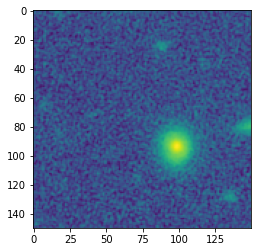

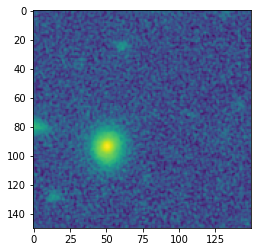

In [120]:
plt.imshow(flipped_image[...,3])
plt.show()
plt.imshow(img[...,3])

In [7]:
import random
def rotation(tensor):
    rand = random.random()
    if rand < 1/3:
        return tf.image.rot90(tensor, k=1)
    elif rand > 2/3:
        return tf.image.rot90(tensor, k=2)
    else:
        return tensor
    
def normalization(cutout): #normalizing all channels and weights for now
    #image percentiles
    img_lower = tfp.stats.percentile(cutout, 0.001, axis = [0,1])
    img_upper = tfp.stats.percentile(cutout, 99.999,axis = [0,1])

    lower_broadcast = tf.ones(tf.shape(cutout), dtype=cutout.dtype) * img_lower
    arr = tf.where(tf.less(cutout, img_lower), lower_broadcast, cutout)

    lower_broadcast = tf.ones(tf.shape(cutout), dtype=cutout.dtype) * img_upper
    arr = tf.where(tf.less(cutout, img_lower), lower_broadcast, cutout)

    img_norm = (cutout - tf.reduce_min(cutout, axis = [0,1])) / (img_upper - img_lower)
    return img_norm

    

In [150]:
mask = tf.concat([tf.ones((100,100)), tf.zeros((100,100))], axis = 0)

#lower_broadcast = tf.ones(tf.shape(cutout), dtype=cutout.dtype) * img_lower


In [151]:
mask

<tf.Tensor: shape=(200, 100), dtype=float32, numpy=
array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [85]:
def preprocess_image(data):
    '''This function applies the following transformation on the data:
    1. normalizing
    2. cropping
    3. rotation
    4. flipping
    5. masking'''
    
    # 1. normalization
    cutout = img_norm(data)     
    
    # 2. cropping &translating
    cutout = tf.image.random_crop(cutout,size = [150,150,10])
    
    # 3. rotating
    cutout = rotation(cutout)
    
    # 4. rotation
    cutout = tf.image.random_flip_left_right(cutout)
    cutout = tf.image.random_flip_up_down(cutout)
    
    # 5. masking
    
    


def prepare_dataset(split):
    # the validation dataset is shuffled as well, because data order matters
    # for the KID calculation
    return (
        tfds.load(dataset_name, split=split, shuffle_files=True)
        .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
        .cache()
        .shuffle(10 * batch_size)
        .batch(batch_size, drop_remainder=True)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )


train_dataset = prepare_dataset("train")
val_dataset = prepare_dataset("test")

ModuleNotFoundError: No module named 'k'

In [ ]:
datagen = keras.preprocesseing.image.ImageDatagenerator(
                             width_shift_range = 15/200,
                             height_shift_range = 15/200,
                             horizontal_flip = True,
                             vertical_flip = True,
                             zoom_range = 
                             preprocessing_function = preprocess_image)

datagen.flow(x_train)